# SongTron

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from classify_notes import *

In [3]:
def kernel_horizontal(bin_im):
    horizontal = np.copy(bin_im)
    rows = horizontal.shape[1]
    size = rows//30
    structure = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    horizontal = cv2.erode(horizontal, structure)
    horizontal = cv2.dilate(horizontal, structure)
    return horizontal

def conv2d_image(f, w):
    N, M = f.shape[0:2]
    n, m = w.shape[0:2]
    w_flip = np.flip(np.flip(w, 0), 1)
    a = n//2  # floor of n/2
    b = m//2  # floor of m/2
    g = np.zeros(f.shape, dtype=np.float)
    for x in range(a, N-a):
        for y in range(b, M-b):
            region_f = f[x-a:x+(a+1), y-b:y+(b+1)]
            g[x][y] = np.sum(np.multiply(region_f.astype(np.float), w_flip.astype(np.float)))
    return g


def otsu_threshold(im):

    # Compute histogram and probabilities of each intensity level
    pixel_counts = [np.sum(im == i) for i in range(256)]
    n, m = im.shape[0:2]
    # Initialization
    s_max = (0,0)

    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)])\
                        / w_0 if w_0 > 0 else 0
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)])\
                        / w_1 if w_1 > 0 else 0

        # calculate - inter class variance
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2

        if s > s_max[1]:
            s_max = (threshold, s)
    return s_max[0]

def threshold(pic, threshold):
    return ((pic < threshold) * 255).astype('uint8')

### Image segmentation stuff

In [4]:
def distance(a, b):
    return np.abs(a-b)

def region_growing_average(img, img_t, tolerance, seed, region_n): 
    x = seed[0]; y = seed[1]
    img_t[x, y] = region_n
    avg = np.mean(img[np.where(img_t==region_n)])
    
    # check matrix border and conquering criterion for the 4-neigbourhood
    if (y+1 < img.shape[1] and img_t[x,y+1] == 0 and distance(avg, img[x, y+1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y+1], region_n)
        
    if (y-1 >= 0 and img_t[x,y-1] == 0  and distance(avg, img[x, y-1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y-1], region_n)
        
    if (x+1 < img.shape[0] and img_t[x+1,y] == 0  and distance(avg, img[x+1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x+1, y], region_n)
        
    if (x-1 >= 0 and img_t[x-1,y] == 0  and distance(avg, img[x-1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x-1, y], region_n)
        
def do_segmentation(image, thresh):
    segment_matrix = np.zeros(image.shape)
    region_counter = 1
    
    #Will check if region is above some treshold
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            pixel_val = image[x, y]
            if segment_matrix[x, y] == 0 and pixel_val >= thresh: #in case not assigned yet
                #print("Pixel {} above threshold".format((x,y)))
                region_growing_average(image, segment_matrix, 10, (x, y), region_counter)
                region_counter += 1
                print("X: {} Y: {} Region: {}".format(x,y,region_counter))
    #print("Segmented regions: {}".format(region_counter))
    return segment_matrix

In [5]:
def get_bounding_rectangle(segment_matrix, segment_number):
    segment_indexes = np.where(segment_matrix == segment_number)
    max_x = segment_indexes[0].max()
    min_x = segment_indexes[0].min()
    max_y = segment_indexes[1].max()
    min_y = segment_indexes[1].min()
    return (min_x, max_x, min_y, max_y)

In [7]:
def main(filename):
    pic = imageio.imread(filename)
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.21 , 0.72, 0.07])

    plt.figure(figsize=(12,12))
    plt.title("Original")
    plt.imshow(pic, cmap='gray')
    plt.axis('off')
    
    bin_img = threshold(gray(pic), otsu_threshold(pic))
    plt.figure(figsize=(12,12))
    plt.title("Binarized")
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')

    lines = kernel_horizontal(bin_img)
    plt.figure(figsize=(12,12))
    plt.title("Lines")
    plt.imshow(lines, cmap='gray')
    plt.axis('off')
    #Here it would be nice if we segmented the lines.
    segmented_lines = do_segmentation(lines, otsu_threshold(pic))

    plt.figure(figsize=(20,20))
    plt.title("Segmented")
    plt.imshow(segmented_lines, cmap='magma')
    plt.axis('off')
    
    bin_img[lines == 255] = 0 
    plt.figure(figsize=(12,12))
    plt.title("Lines removed")
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')
    """
    blurred = cv2.medianBlur(bin_img, 5)
    plt.figure(figsize=(12,12))
    plt.title("Blurred")
    plt.imshow(blurred, cmap='gray')
    plt.axis('off')
    """

    #Morphological closing.
    kernel = np.ones((4,1),np.uint8)
    closing = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)

    plt.figure(figsize=(12,12))
    plt.title("Morphological Close")
    plt.imshow(closing, cmap='gray')
    plt.axis('off')
    segmented_notes = do_segmentation(closing, otsu_threshold(pic))
    
    mask = np.zeros(segmented_notes.shape)
    mask[segmented_notes > 0] = 1
    
    plt.figure(figsize=(20,20))
    plt.title("Segmented")
    plt.imshow(segmented_notes, cmap='magma')
    plt.axis('off')

    plt.figure(figsize=(20,20))
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    #Dilating image now...
    kernel_dilate = np.ones((3,3),np.uint8)
    dilated_mask = cv2.dilate(mask, kernel_dilate)
    
    plt.figure(figsize=(20,20))
    plt.title("Dilated mask")
    plt.imshow(dilated_mask, cmap='gray')
    plt.axis('off')
    
    #Notes on observation. Just wrong to be here but easier.
    #interest_notes = [86]#[1, 7, 8, 9, 13, 14, 15, 19, 21]
    
    bounding_boxes = []
    
    for region in np.unique(segmented_notes):
        ranges = get_bounding_rectangle(segmented_notes, region)
        bounding_boxes.append(ranges)
    """
        print("Reg. {} Ranges are {}".format(region, ranges))
        temp = np.copy(closing)
        img = temp[ranges[0]:ranges[1],ranges[2]:ranges[3]]
        if region in interest_notes:
            #then lets save this...
            save_str = "../datasets/minim/{}.png".format(region)
            print("Saving to" + save_str)
            imageio.imwrite(save_str, img)
        plt.figure(figsize=(1,1))
        plt.title("Figure nº {}".format(region))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    """
    #plt.show()
    clf = Classify_notes(closing, bounding_boxes)
    print(list(clf.get_classified_notes()))

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
X: 4 Y: 34 Region: 2
X: 10 Y: 78 Region: 3
X: 10 Y: 96 Region: 4
X: 20 Y: 43 Region: 5
X: 27 Y: 43 Region: 6
X: 55 Y: 37 Region: 7
X: 60 Y: 235 Region: 8
X: 60 Y: 326 Region: 9
X: 60 Y: 417 Region: 10
X: 74 Y: 5 Region: 11
X: 76 Y: 82 Region: 12
X: 76 Y: 493 Region: 13
X: 76 Y: 624 Region: 14
X: 76 Y: 715 Region: 15
X: 76 Y: 806 Region: 16
X: 76 Y: 882 Region: 17
X: 76 Y: 1179 Region: 18
X: 76 Y: 1187 Region: 19
X: 82 Y: 533 Region: 20
X: 91 Y: 1023 Region: 21
X: 105 Y: 139 Region: 22
../assets/reference/crotchet/0.png
../assets/reference/crotchet/1.png
../assets/reference/crotchet/2.png
../assets/reference/crotchet/3.png
../assets/reference/crotchet/4.png
../assets/reference/crotchet/5.png
../assets/reference/crotchet/6.png
../assets/reference/crotchet/7.png
../assets/reference/crotchet/8.png
../assets/reference/crotchet/9.png
../assets/reference/crotchet/10.png
../assets/reference/crotchet/11.png
..

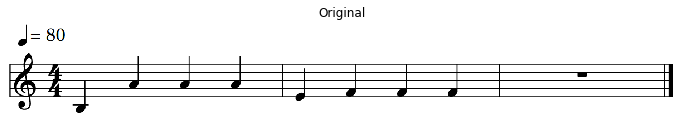

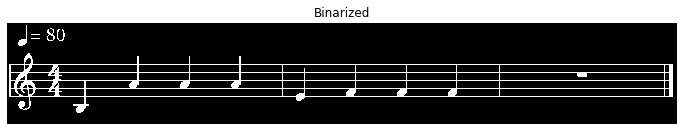

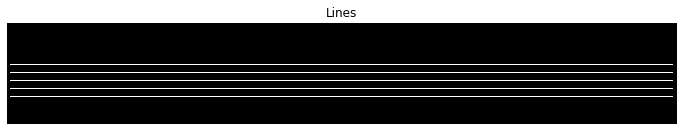

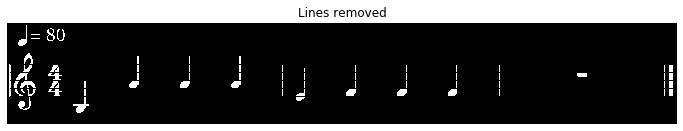

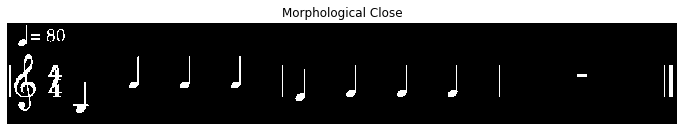

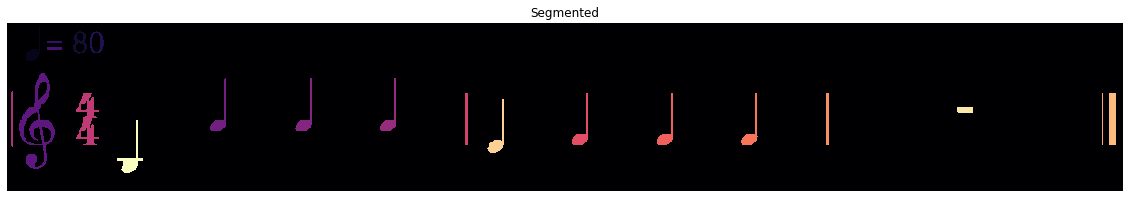

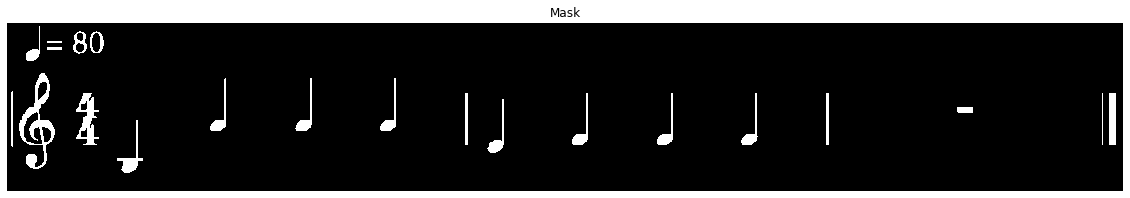

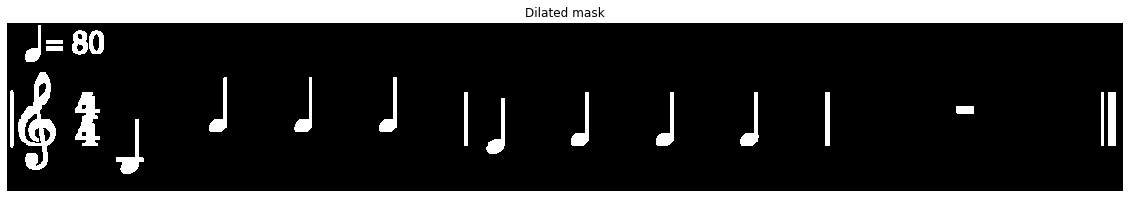

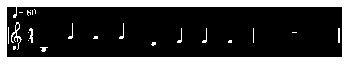

Error: [0.04986180297836318, 0.018989125994593348, 12.288991757145475]
Imagem passou no crivo de aristóteles!


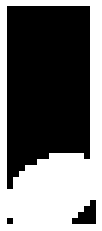

Error: [0.004724624900441121, 0.022391469916222373, 16.820429761447436]
Imagem passou no crivo de aristóteles!


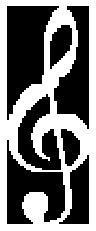

Error: [0.0426695676780075, 0.10070199369652638, 8.524623941053521]
Imagem passou no crivo de aristóteles!


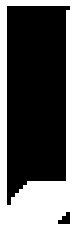

Error: [0.04831557608136883, 0.08284485083938353, 8.24413613617547]
Imagem passou no crivo de aristóteles!


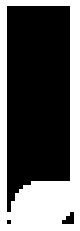

Error: [0.04155349624943608, 0.10070199369652638, 8.331156604370102]
Imagem passou no crivo de aristóteles!


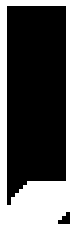

Error: [0.03296989235333217, 0.09550718850172119, 8.418712611004262]
Imagem passou no crivo de aristóteles!


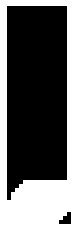

Error: [0.0341062559896958, 0.09550718850172119, 8.440465525211936]
Imagem passou no crivo de aristóteles!


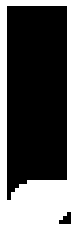

Error: [0.001588931176079611, 0.077325370319903, 6.153656199118036]
Imagem passou no crivo de aristóteles!


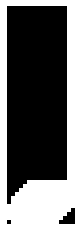

Error: [0.037645518584685955, 0.08817066537572438, 9.673025767537538]
Imagem passou no crivo de aristóteles!


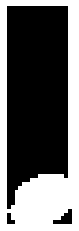

Error: [0.042988445229027894, 0.11358372058918792, 6.958149952614214]
Imagem passou no crivo de aristóteles!


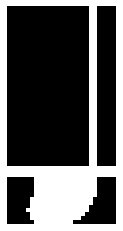

[('crotchet',), ('crotchet',), ('treble',), ('crotchet',), ('crotchet',), ('crotchet',), ('crotchet',), ('crotchet',), ('crotchet',), ('crotchet',), ('crotchet',)]


In [6]:
file1 = "../assets/songtron_test_0.png"
main(file1)

In [ ]:
file2 = "../assets/danse_macabre_cut_0.png"
main(file2)

X: 24 Y: 23 Region: 2
X: 31 Y: 23 Region: 3
X: 37 Y: 23 Region: 4
X: 44 Y: 23 Region: 5
X: 51 Y: 23 Region: 6
X: 125 Y: 9 Region: 7
X: 132 Y: 9 Region: 8
X: 139 Y: 9 Region: 9
X: 146 Y: 9 Region: 10
X: 153 Y: 9 Region: 11
X: 227 Y: 9 Region: 12
X: 234 Y: 9 Region: 13
X: 241 Y: 9 Region: 14
X: 248 Y: 9 Region: 15
X: 255 Y: 9 Region: 16
X: 11 Y: 33 Region: 2
X: 15 Y: 594 Region: 3
X: 15 Y: 680 Region: 4
X: 15 Y: 706 Region: 5
X: 16 Y: 53 Region: 6
X: 18 Y: 556 Region: 7
X: 19 Y: 142 Region: 8
X: 19 Y: 237 Region: 9
X: 19 Y: 617 Region: 10
X: 20 Y: 262 Region: 11
X: 20 Y: 333 Region: 12
X: 20 Y: 407 Region: 13
X: 20 Y: 454 Region: 14
X: 20 Y: 498 Region: 15
X: 20 Y: 534 Region: 16
X: 24 Y: 67 Region: 17
X: 25 Y: 22 Region: 18
X: 26 Y: 46 Region: 19
X: 26 Y: 90 Region: 20
X: 26 Y: 124 Region: 21
X: 26 Y: 168 Region: 22
X: 26 Y: 180 Region: 23
X: 26 Y: 205 Region: 24
X: 26 Y: 219 Region: 25
X: 26 Y: 270 Region: 26
X: 26 Y: 282 Region: 27
X: 26 Y: 307 Region: 28
X: 26 Y: 344 Region: 29
X: 26

In [ ]:
file3 = "../assets/asa_branca.jpg"
main(file3)

# Just lines here lol

In [ ]:
#so this function will only find lines' height
#image should suffer some dilation...
def find_lines_height(img, thresh):
    lines_found_heights = []
    x,y = img.shape
    search_y = y//2
    inside_line = False
    
    for temp_x in range(x):
        if img[temp_x, search_y] > thresh: #were are in a white pixel
            print("Pixel {} is above thresh.".format((temp_x, search_y)))
            if not inside_line:
                lines_found_heights.append(temp_x)
            inside_line = True
        else:
            inside_line = False

    return lines_found_heights